In [1]:
import datetime
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import casadi as cas
import pickle
import copy as cp


# from ..</src> import car_plotting
# from .import src.car_plotting
PROJECT_PATH = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/'
sys.path.append(PROJECT_PATH)


import src.MPC_Casadi as mpc
import src.TrafficWorld as tw
import src.IterativeBestResponseMPCMultiple as mibr

np.set_printoptions(precision=2)

In [28]:

NEW = True
if NEW:
    optional_suffix = "testsave"
    subdir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + optional_suffix
    folder = "results/" + subdir_name + "/"
    os.makedirs(folder)
    os.makedirs(folder+"imgs/")
    os.makedirs(folder+"data/")
    os.makedirs(folder+"vids/")
else:
    subdir_name = "20200224-103456_real_dim_CA"
    folder = "results/" + subdir_name + "/"
print(folder)



T = 10 #numbr of time horizons
dt = 0.2
N = int(T/dt) #Number of control intervals
world = tw.TrafficWorld(2, 0, 1000)
# Initial Conditions

all_other_x0 = []
all_other_u = []
n_other = 2

all_other_MPC = []
next_x0 = 0
for i in range(n_other):
    x1_MPC = mpc.MPC(dt)
    x1_MPC.theta_iamb = np.pi/2.5
    x1_MPC.k_final = 1.0
    x1_MPC.k_s = -2.0
    # x1_MPC.k_s = 0.0
    # x1_MPC.k_x = -1.0

    x1_MPC.min_y = world.y_min
    x1_MPC.max_y = world.y_max

    x1_MPC.k_u_v = 0.10
    x1_MPC.k_u_delta = 0.10
    x1_MPC.k_lat = 1.0
    # x1_MPC.k_change_u_v = 1.0
    # x1_MPC.k_change_u_delta = 1.0

    if i%2 == 0:
        lane_number = 0
        next_x0 += x1_MPC.L/2.0 + 2*x1_MPC.min_dist
    else:
        lane_number = 1
    
    initial_speed = 20 * 0.447 # m/s
    x1_MPC.fd = x1_MPC.gen_f_desired_lane(world, lane_number, True)
    x0 = np.array([next_x0, world.get_lane_centerline_y(lane_number), 0, 0, initial_speed, 0]).T
    u1 = np.zeros((2,N))
    u1[0,:] = np.clip(np.pi/180 *np.random.normal(size=(1,N)), -2 * np.pi/180, 2 * np.pi/180)
#     u1[0,:] = np.ones((1,N)) * np.pi/6
    # u1[1,:] = np.clip(np.random.normal(size=(1,N)), -x1_MPC.max_acceleration * x1_MPC.dt, x1_MPC.max_acceleration * x1_MPC.dt)
    all_other_MPC += [x1_MPC]
    all_other_x0 += [x0]
    all_other_u += [u1]    

amb_MPC = cp.deepcopy(x1_MPC)
amb_MPC.theta_iamb = 0.0

amb_MPC.k_u_v = 0.10
amb_MPC.k_u_delta = 1.0
amb_MPC.k_change_u_v = 0.01
amb_MPC.k_change_u_delta = 0.0
amb_MPC.k_phi
amb_MPC.k_x = -1/10000.0
amb_MPC.k_s = 0
# amb_MPC.min_v = initial_speed  
# amb_MPC.k_u_change = 1.0
# amb_MPC.k_lat = 0
amb_MPC.k_lon = 0.0
# amb_MPC.k_s = -2.0
amb_MPC.max_v = 40 * 0.447 # m/s
# amb_MPC.max_X_dev = 5.0



amb_MPC.fd = amb_MPC.gen_f_desired_lane(world, 0, True)

x0_amb = np.array([0, 0, 0, 0, 1.1*initial_speed , 0]).T
uamb = np.zeros((2,N))
uamb[0,:] = np.clip(np.pi/180 * np.random.normal(size=(1,N)), -2 * np.pi/180, 2 * np.pi/180)
amb_MPC.min_v = 1.1*initial_speed


results/20200226-125359testsave/


In [ ]:
WARM = True
n_total_round = 60
ibr_sub_it = 1
runtimeerrors = 0
min_slack = 100000.0
for n_round in range(n_total_round):
    response_MPC = amb_MPC
    response_x0 = x0_amb
    
    nonresponse_MPC_list = all_other_MPC
    nonresponse_x0_list = all_other_x0
    nonresponse_u_list = all_other_u
    bri = mibr.IterativeBestResponseMPCMultiple(response_MPC, None, nonresponse_MPC_list )
    bri.k_slack = 999
    bri.generate_optimization(N, T, response_x0, None, nonresponse_x0_list,  5, slack=True)
    bri.solve(None, nonresponse_u_list)
    x1, u1, x1_des, _, _, _, other_x, other_u, other_des = bri.get_solution()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4230
Number of nonzeros in inequality constraint Jacobian.:     3466
Number of nonzeros in Lagrangian Hessian.............:     3648

Total number of variables............................:     2293
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1377
Total number of inequality constraints...............:      967
        inequality constraints with only lower bounds:      204
   inequality constraints with lower and upper bounds:      355
        inequality constraints with only upper bounds:      408

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

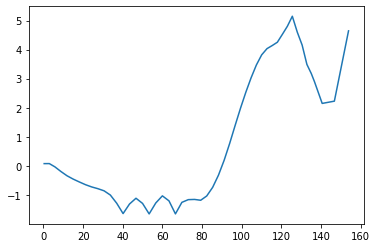

In [26]:
x1 = bri.opti.debug.value(bri.x_opt)
plt.plot(x1[0,:], x1[1,:])

In [27]:
costs = ["self.k_u_delta * self.u_delta_cost",
            "self.k_u_v * self.u_v_cost",
            "self.k_lat * self.lat_cost", 
            "self.k_lon * self.lon_cost", 
            "self.k_phi_error * self.phi_error_cost",
            "self.k_phi_dot * self.phidot_cost",
            "self.k_s * self.s_cost",
            "self.k_v * self.v_cost",
            "self.k_change_u_v * self.change_u_v",
            "self.k_change_u_delta * self.change_u_delta", 
            "self.k_final * self.final_costs",
            "self.k_x * self.x_cost"]


for i in range(len(bri.car1_costs_list)):
    amb_costs = bri.opti.debug.value(bri.car1_costs_list[i])
    print('%.03f'%amb_costs, costs[i])
    
print(bri.opti.debug.value(bri.slack_cost))

0.157 self.k_u_delta * self.u_delta_cost
3.246 self.k_u_v * self.u_v_cost
296.473 self.k_lat * self.lat_cost
0.000 self.k_lon * self.lon_cost
25.852 self.k_phi_error * self.phi_error_cost
186.438 self.k_phi_dot * self.phidot_cost
0.000 self.k_s * self.s_cost
0.000 self.k_v * self.v_cost
0.373 self.k_change_u_v * self.change_u_v
0.000 self.k_change_u_delta * self.change_u_delta
50.985 self.k_final * self.final_costs
-39.603 self.k_x * self.x_cost
12634778.361273078
